# Results

This notebook shows how to work with the results from the joint Crab paper.

We will give a quick overview of the files in the `results` folder, and then show how to load the spectral fit results (best-fit parameters and covariance matrix) and make a plot of the parameter constraints.

As explained in the [README.md](README.md), the main analysis and the figures for this paper were produced by Python scripts (`make.py` and `joint_crab` package). For further examples, please look there.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import yaml
import numpy as np
import pandas as pd
from multinorm import MultiNorm
from astropy.table import Table

## Overview

All results are stored in standard machine-readable formats that are easy to read from Python. We used the YAML format for structured data (using the Python `yaml` package), ECSV and FITS for table (using the Python `astropy` package).

In [3]:
!ls -1 results

README.md
errorbands
figures
fit
maps
provenance.yaml
spectra
summary


In [4]:
!ls -1 results/fit

contours_fact.yaml
contours_fermi.yaml
contours_hess.yaml
contours_joint.yaml
contours_joint_systematics.yaml
contours_magic.yaml
contours_veritas.yaml
fit_fact.yaml
fit_fermi.yaml
fit_hess.yaml
fit_joint.yaml
fit_joint_systematics.yaml
fit_magic.yaml
fit_veritas.yaml


In [5]:
!ls -1 results/errorbands

samples_fact.fits.gz
samples_fermi.fits.gz
samples_hess.fits.gz
samples_joint.fits.gz
samples_magic.fits.gz
samples_veritas.fits.gz
sed_fact.ecsv
sed_fermi.ecsv
sed_hess.ecsv
sed_joint.ecsv
sed_magic.ecsv
sed_veritas.ecsv


In [6]:
!ls -1 results/summary/

data.md
data.tex
results.md
results.tex


## Read YAML fit results

The fit results are given in the files `results/fit/fit_{name}.yaml`, where `name = {"fermi", "magic", "veritas", "fact", "hess", "joint"}`. As an example, you can look at [results/fit/fit_fermi.yaml](results/fit/fit_fermi.yaml) to see the structure. For each fit parameter, there's the name, value and error, and there's also the covariance matrix.

In [7]:
info = yaml.load(open("results/fit/fit_joint.yaml"))
info

{'parameters': [{'name': 'amplitude',
   'value': 3.8491280706505666e-11,
   'factor': 3.8491280706505666,
   'scale': '1e-11',
   'unit': 'cm-2 s-1 TeV-1',
   'min': nan,
   'max': nan,
   'frozen': False,
   'error': 1.1435170001020147e-12},
  {'name': 'reference',
   'value': 1.0,
   'factor': 1.0,
   'scale': 1.0,
   'unit': 'TeV',
   'min': nan,
   'max': nan,
   'frozen': True,
   'error': 0.0},
  {'name': 'alpha',
   'value': 2.5053735278333207,
   'factor': 2.5053735278333207,
   'scale': 1.0,
   'unit': '',
   'min': nan,
   'max': nan,
   'frozen': False,
   'error': 0.02549508100457278},
  {'name': 'beta',
   'value': 0.2362106123242955,
   'factor': 2.3621061232429548,
   'scale': 0.1,
   'unit': '',
   'min': nan,
   'max': nan,
   'frozen': False,
   'error': 0.02450886256203386}],
 'covariance': [[1.3076311295223112e-24,
   0.0,
   1.2371922299026042e-16,
   1.1603842009321198e-14],
  [0.0, 0.0, 0.0, 0.0],
  [1.2371922299026042e-16, 0.0, 0.0006499991554297277, 0.00049214

Usually you'll have to write a few lines of code to get the data in the form you want.

For example, here's how to put the parameter information into a `pandas.DataFrame`:

In [8]:
pd.DataFrame(
    [
        {"name": _["name"], "value": _["value"], "error": _["error"]}
        for _ in info["parameters"]
    ],
    columns=["name", "value", "error"],
)

,name,value,error
0,amplitude,3.849128e-11,1.143517e-12
1,reference,1.000000e+00,0.000000e+00
2,alpha,2.505374e+00,2.549508e-02
3,beta,2.362106e-01,2.450886e-02


The `yaml.load` call returns Python objects (str, float, list, dict). Often for computations you want a Numpy array. It's easy to make:

In [9]:
cov = np.array(info["covariance"])
cov

array([[1.30763113e-24, 0.00000000e+00, 1.23719223e-16, 1.16038420e-14],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.23719223e-16, 0.00000000e+00, 6.49999155e-04, 4.92142818e-04],
       [1.16038420e-14, 0.00000000e+00, 4.92142818e-04, 6.00684344e-04]])

## Check parameter correlations

If you look at Table 2 or Figure 4 in the paper, you will find that the parameter errors in the joint fit are much smaller than the parameter errors from each individual instrument dataset.

Why is that?

The reason is that there are strong correlations between the three fit parameters, especially for the Fermi-LAT dataset. The likelihood for each dataset is approximately a three-dimensional multivariate normal, and the joint likelihood is approximately the product of those likelihood, and the parameter correlations lead to a well-constrained joint likelihood.

Let's load all fit results and compute the product multivariate normal, and then create a Figure similar to Fig. 4 in the paper. We will use the `MultiNorm` class from the [multinorm](https://multinorm.readthedocs.io/) module to help a bit with the covariance matrix related computations.

### Load all results

First let's load all fit results, and store each one in a `MultiNorm` object:

In [10]:
def read_fit_result(name):
    data = yaml.load(open(f"results/fit/fit_{name}.yaml"))
    mean = [_["value"] for _ in data["parameters"]]
    cov = data["covariance"]
    # Use parameter names that are consistent with the paper
    names = ["phi", "reference", "gamma", "beta"]
    mn = MultiNorm(mean, cov, names)
    mn = mn.drop(["reference"])
    return mn


results = {
    name: read_fit_result(name)
    for name in ("fermi", "magic", "veritas", "fact", "hess", "joint")
}

### Check results

We can now do any covariance-matrix related computations, e.g. to compute parameter errors or correlations:

In [11]:
# These are the numbers in the last row in Table 2 in the paper
results["joint"].parameters

,mean,err
name,,
phi,3.849128e-11,1.143517e-12
gamma,2.505374e+00,2.549508e-02
beta,2.362106e-01,2.450886e-02


In [12]:
# The parameter correlations for Fermi-LAT are very high
results["fermi"].correlation

name,phi,gamma,beta
name,,,
phi,1.000000,-0.910732,-0.797599
gamma,-0.910732,1.000000,0.972449
beta,-0.797599,0.972449,1.000000


In [13]:
results["fermi"].correlation["phi"]["gamma"]

-0.9107317393899312

### Product likelihood

Let's compute the product multivariate normal, which is an approximation for the joint fit result.

In [14]:
def compute_joint_product_result(results):
    labels = ["fermi", "magic", "veritas", "fact", "hess"]
    distributions = [results[_] for _ in labels]
    mn = MultiNorm.from_product(distributions)
    return mn


results["product"] = compute_joint_product_result(results)

In [15]:
results["product"].parameters

,mean,err
name,,
phi,3.828777e-11,1.188333e-12
gamma,2.489757e+00,2.765209e-02
beta,2.203237e-01,2.569859e-02


In [16]:
results["joint"].parameters

,mean,err
name,,
phi,3.849128e-11,1.143517e-12
gamma,2.505374e+00,2.549508e-02
beta,2.362106e-01,2.450886e-02


### Plot

Let's plot the 2-dimensional parameter contraints ("1 sigma error ellipses") for each pair of parameters.

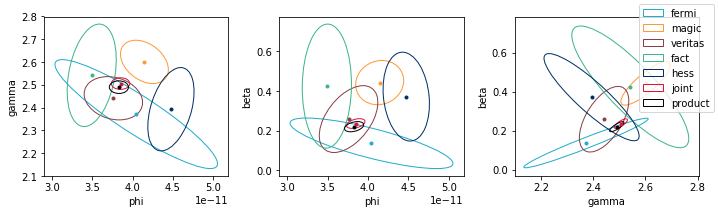

In [17]:
def plot_ellipses_panel(results, names, ax):
    colors = [
        "#21ABCD",
        "#FF9933",
        "#893F45",
        "#3EB489",
        "#002E63",
        "crimson",
        "black",
    ]
    for name, color in zip(results, colors):
        m = results[name].marginal(names)
        ellipse = m.to_matplotlib_ellipse(ec=color, fc="none", label=name)
        ax.add_patch(ellipse)
        ax.plot(m.mean[0], m.mean[1], ".", color=color)
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])


def plot_ellipses(results):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    plot_ellipses_panel(results, ["phi", "gamma"], axes[0])
    plot_ellipses_panel(results, ["phi", "beta"], axes[1])
    plot_ellipses_panel(results, ["gamma", "beta"], axes[2])
    fig.legend()
    fig.tight_layout()


plot_ellipses(results)

As mentioned at the start, we can see that the joint fit result is approximately given by the product of the multivariate normal approximation for the fit result of each individual dataset in this analysis.

## SED

In `results/errorbands`, the SEDs corresponding to the best-fit model are pre-computed, including 1 sigma error bands. Here we show how to upen up such a table and plot the SED.

In [18]:
sed = Table.read("results/errorbands/sed_veritas.ecsv")

In [19]:
sed.info()

<Table length=81>
     name      dtype        unit      format
------------- ------- --------------- ------
       energy float64             TeV     3g
    dnde_mean float64 1 / (cm2 s TeV)     3g
  dnde_median float64 1 / (cm2 s TeV)     3g
      dnde_lo float64 1 / (cm2 s TeV)     3g
      dnde_hi float64 1 / (cm2 s TeV)     3g
     dnde_fit float64 1 / (cm2 s TeV)     3g
   e2dnde_fit float64   erg / (cm2 s)     3g
  e2dnde_mean float64   erg / (cm2 s)     3g
e2dnde_median float64   erg / (cm2 s)     3g
    e2dnde_lo float64   erg / (cm2 s)     3g
    e2dnde_hi float64   erg / (cm2 s)     3g


Text(0,0.5,'E^2 (dN/dE) (erg cm-2 s-1)')

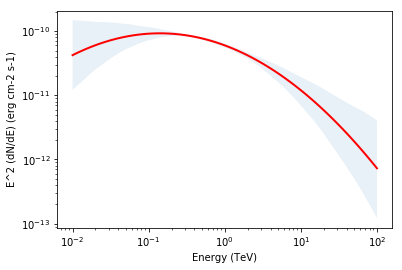

In [20]:
fig, ax = plt.subplots()
ax.plot(sed["energy"], sed["e2dnde_fit"], lw=2, c="r")
ax.fill_between(sed["energy"], sed["e2dnde_lo"], sed["e2dnde_hi"], alpha=0.1)
ax.loglog()
ax.set_xlabel("Energy (TeV)")
ax.set_ylabel("E^2 (dN/dE) (erg cm-2 s-1)")

Some key points to take away:

- YAML is great to store structured data, and easy to read / write with the Python `yaml` module.
- ECSV is nice to store tabular data if you use `astropy.table.Table`.
- FITS is also a good format for tabular data. It supports columns which contain multidimensional arrays, which ECSV does not.
- Separate computation from plotting, for easier reproducibility, debugging and re-use.